# Setup and Initialization

## Import Library

In [5]:
import re
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler
)

from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Load Data

In [6]:
df = pd.read_excel('anode.xlsx')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124982 entries, 0 to 124981
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   No.                          124982 non-null  int64  
 1   Kode Produksi                124982 non-null  object 
 2   LOT                          124982 non-null  object 
 3   Nomor Cetak                  124982 non-null  int64  
 4   Type                         124982 non-null  object 
 5   Mould                        124982 non-null  int64  
 6   Binder                       124982 non-null  float64
 7   Weight (Kg)                  124982 non-null  float64
 8   Height (mm)                  124982 non-null  float64
 9   AD (GCC)                     124982 non-null  float64
 10  Temperature                  124982 non-null  float64
 11  Time Shaking                 124982 non-null  float64
 12  Capacity                     124982 non-null  float64
 13 

# Data Pre-Processing

## Data Cleaning

In [8]:
df_cl = df.copy()

### Check Null Values

In [9]:
df_cl.isnull().sum()

No.                         0
Kode Produksi               0
LOT                         0
Nomor Cetak                 0
Type                        0
                        ...  
Deformation Hole 4      28946
Oxidation Surface       28946
Oxidation Short Side    28946
Oxidation Long Side     28946
Coke Sticking           28946
Length: 77, dtype: int64

In [10]:
missing_values = df_cl.isnull().sum()

missing_values_df = pd.DataFrame(
    data=missing_values,
    columns=['missing_values_count'],
)

missing_values_df.sort_values(by='missing_values_count', ascending=False, inplace=True)
missing_values_df

,missing_values_count
Rantai Bakar,35687
Laju Pembakaran,34868
JenisKurva,34697
Oxidation Surface,28946
Deformation Hole 4,28946
...,...
Kode Produksi,0
No.,0
Weight (Kg),0
Binder,0


### Handling Duplicated Data

In [11]:
df_cl.dropna(axis=0, inplace=True)

### Check Duplicated Data

In [12]:
df_cl.duplicated().sum()

np.int64(0)

### Check Outlier

In [13]:
def detect_outliers_robust(df, method='iqr', threshold=3.5, visualize=True):
    df_flagged = df.copy()
    numeric_cols = df_flagged.select_dtypes(include=[np.number]).columns
    summary = []

    for col in numeric_cols:
        data = df_flagged[col].dropna()

        if method == 'iqr':
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - threshold * IQR, Q3 + threshold * IQR
            outliers = (df_flagged[col] < lower) | (df_flagged[col] > upper)
        
        elif method == 'mad':
            median = np.median(data)
            mad = np.median(np.abs(data - median))
            if mad == 0:
                outliers = pd.Series(False, index=data.index)
            else:
                modified_z = 0.6745 * (data - median) / mad
                outliers = np.abs(modified_z) > threshold
        
        else:
            raise ValueError("Metode tidak dikenal. Gunakan 'iqr' atau 'mad'.")

        # Simpan flag di DataFrame
        df_flagged[f'{col}_is_outlier'] = outliers

        # Hitung persentase outlier
        outlier_pct = outliers.mean() * 100
        summary.append({
            'Column': col,
            'Method': method.upper(),
            'Outlier_Count': outliers.sum(),
            'Outlier_%': round(outlier_pct, 3),
            'Skewness': round(df_flagged[col].skew(), 3)
        })

    summary_df = pd.DataFrame(summary).sort_values('Outlier_%', ascending=False)
    
    print(f"✅ Deteksi outlier selesai ({method.upper()} method)")
    display(summary_df)

    return summary_df, df_flagged

In [14]:
summary_iqr, df_outliers_iqr = detect_outliers_robust(df_cl, method='iqr', threshold=1.5)

✅ Deteksi outlier selesai (IQR method)


,Column,Method,Outlier_Count,Outlier_%,Skewness
6,AD (GCC),IQR,9402,11.429,-41.094
23,KN201 V,IQR,7649,9.298,-1.281
22,KN201 RPM,IQR,3216,3.909,-1.720
29,SM201,IQR,3070,3.732,56.246
7,Temperature,IQR,2959,3.597,-7.683
24,KN202 AMP,IQR,2355,2.863,0.857
31,TRA722,IQR,2134,2.594,232.669
33,TRCA16,IQR,2017,2.452,230.561
25,KN202 KW,IQR,2001,2.432,-0.073
30,TRA721,IQR,1745,2.121,274.911


## Feature Engineering

In [15]:
df_fe = df_cl.copy()

### Drop Unnecesary Feature

In [16]:
df_fe.columns

Index(['No.', 'Kode Produksi', 'LOT', 'Nomor Cetak', 'Type', 'Mould', 'Binder',
       'Weight (Kg)', 'Height (mm)', 'AD (GCC)', 'Temperature', 'Time Shaking',
       'Capacity', 'CH6 MBar', 'B201', 'B202', 'B203', 'B204', 'B206', 'B207',
       'B208', 'S201', 'S202', 'KN201 AMP', 'KN201 KW', 'KN201 RPM', 'KN201 V',
       'KN202 AMP', 'KN202 KW', 'KN202 RPM', 'KN202 V', 'PH201', 'SM201',
       'TRA721', 'TRA722', 'TRCA1', 'TRCA16', 'TRCA2', 'TRA3', 'Power Mixing',
       'Gedung', 'Tungku', 'Layer', 'Saggar', 'Block', 'Kode Baking',
       'Laju Pembakaran', 'JenisKurva', 'Rantai Bakar', 'mrg_label',
       'BB Inspection Created', 'Transport Code', 'Shift', 'Crack General',
       'Sompel General', 'Deformation General', 'Oxidation General',
       'Crack Body Hole 13', 'Crack Body Hole 24', 'Crack Long Side Vertical',
       'Crack Long Side Horizontal', 'Crack Short Side Vertical',
       'Crack Short Side Horizontal', 'Sompel Hole 1', 'Sompel Hole 2',
       'Sompel Hole 3', 'So

In [17]:
identifier_cols = ['No.', 'Kode Produksi', 'Nomor Cetak']

leakage_cols = ['mrg_label', 'Sompel General', 'Deformation General', 'Oxidation General',
        'Crack Body Hole 13', 'Crack Body Hole 24', 'Crack Long Side Vertical',
        'Crack Long Side Horizontal', 'Crack Short Side Vertical',
        'Crack Short Side Horizontal', 'Sompel Hole 1', 'Sompel Hole 2',
        'Sompel Hole 3', 'Sompel Hole 4', 'Sompel Short Side',
        'Sompel Long Side', 'Deformation Hole 1', 'Deformation Hole 2',
        'Deformation Hole 3', 'Deformation Hole 4', 'Oxidation Surface',
        'Oxidation Short Side', 'Oxidation Long Side', 'Coke Sticking']

no_variance_col = ['JenisKurva']

irrelevant_col = ['Kode Baking', 'Transport Code']

cols_to_remove = identifier_cols + leakage_cols + no_variance_col + irrelevant_col

In [18]:
df_fe.drop(columns=cols_to_remove, inplace=True)

In [19]:
df_fe.columns

Index(['LOT', 'Type', 'Mould', 'Binder', 'Weight (Kg)', 'Height (mm)',
       'AD (GCC)', 'Temperature', 'Time Shaking', 'Capacity', 'CH6 MBar',
       'B201', 'B202', 'B203', 'B204', 'B206', 'B207', 'B208', 'S201', 'S202',
       'KN201 AMP', 'KN201 KW', 'KN201 RPM', 'KN201 V', 'KN202 AMP',
       'KN202 KW', 'KN202 RPM', 'KN202 V', 'PH201', 'SM201', 'TRA721',
       'TRA722', 'TRCA1', 'TRCA16', 'TRCA2', 'TRA3', 'Power Mixing', 'Gedung',
       'Tungku', 'Layer', 'Saggar', 'Block', 'Laju Pembakaran', 'Rantai Bakar',
       'BB Inspection Created', 'Shift', 'Crack General'],
      dtype='object')

### Handling Category Num Features

In [20]:
num_cols = df_fe.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_fe.select_dtypes(include=['object']).columns

In [21]:
cat_cols

Index(['LOT', 'Type', 'Gedung', 'Layer', 'Saggar', 'Rantai Bakar',
       'BB Inspection Created', 'Crack General'],
      dtype='object')

In [22]:
num_cols

Index(['Mould', 'Binder', 'Weight (Kg)', 'Height (mm)', 'AD (GCC)',
       'Temperature', 'Time Shaking', 'Capacity', 'CH6 MBar', 'B201', 'B202',
       'B203', 'B204', 'B206', 'B207', 'B208', 'S201', 'S202', 'KN201 AMP',
       'KN201 KW', 'KN201 RPM', 'KN201 V', 'KN202 AMP', 'KN202 KW',
       'KN202 RPM', 'KN202 V', 'PH201', 'SM201', 'TRA721', 'TRA722', 'TRCA1',
       'TRCA16', 'TRCA2', 'TRA3', 'Power Mixing', 'Tungku', 'Block',
       'Laju Pembakaran', 'Shift'],
      dtype='object')

In [23]:
category_num_cols = ['Shift', 'Tungku', 'Mould', 'Block']

In [24]:
cat_cols = cat_cols.tolist() + category_num_cols

In [25]:
df_fe[cat_cols] = df_fe[cat_cols].astype('str')

### Make New Features

In [26]:
# ========== GEOMETRI & DENSITAS ==========
df_fe["density_geom"] = df_fe["Weight (Kg)"] / (df_fe["Height (mm)"] + 1)
df_fe["weight_per_ad"] = df_fe["Weight (Kg)"] / (df_fe["AD (GCC)"] + 1)

In [27]:
# ========== MIXING & FORMING ==========
df_fe["mixing_energy"] = df_fe["Power Mixing"] * df_fe["Time Shaking"]
df_fe["press_intensity"] = df_fe["Capacity"] * df_fe["CH6 MBar"]

In [28]:
# ========== MESIN ==========
df_fe["kn201_power_ratio"] = df_fe["KN201 KW"] / (df_fe["KN201 RPM"] + 1)
df_fe["kn202_power_ratio"] = df_fe["KN202 KW"] / (df_fe["KN202 RPM"] + 1)
df_fe["kn201_load"] = df_fe["KN201 AMP"] / (df_fe["KN201 V"] + 1)
df_fe["kn202_load"] = df_fe["KN202 AMP"] / (df_fe["KN202 V"] + 1)

In [29]:
# ========== BAKING ZONE ==========
bake_cols = ["TRA721","TRA722","TRCA1","TRCA16","TRCA2","TRA3"]
bake_cols = [c for c in bake_cols if c in df_fe.columns]

df_fe["bake_mean"] = df_fe[bake_cols].mean(axis=1)
df_fe["bake_max"]  = df_fe[bake_cols].max(axis=1)
df_fe["bake_min"]  = df_fe[bake_cols].min(axis=1)
df_fe["bake_range"] = df_fe["bake_max"] - df_fe["bake_min"]
df_fe["bake_std"]   = df_fe[bake_cols].std(axis=1)

In [30]:
# ========== PEMBAKARAN ==========
# df_fe["burn_intensity"] = df_fe["Laju Pembakaran"] * df_fe["Rantai Bakar"]
df_fe["burn_vs_weight"] = df_fe["Laju Pembakaran"] / (df_fe["Weight (Kg)"] + 1)

In [31]:
# ========== BINDER ==========
df_fe["binder_x_burn"] = df_fe["Binder"] * df_fe["Laju Pembakaran"]
df_fe["binder_x_temp"] = df_fe["Binder"] * df_fe["Temperature"]

In [32]:
# ========== INTERAKSI FISIK ==========
df_fe["density_x_temp"] = df_fe["density_geom"] * df_fe["Temperature"]
df_fe["weight_x_temp"]  = df_fe["Weight (Kg)"] * df_fe["Temperature"]
df_fe["bake_x_burn"]    = df_fe["bake_mean"] * df_fe["Laju Pembakaran"]

In [33]:
# ========== DEVIASI PER TUNGKU ==========
if "Tungku" in df_fe.columns:
    df_fe["temp_dev_tungku"] = df_fe["Temperature"] - df_fe.groupby("Tungku")["Temperature"].transform("mean")
    df_fe["burn_dev_tungku"] = df_fe["Laju Pembakaran"] - df_fe.groupby("Tungku")["Laju Pembakaran"].transform("mean")

In [34]:
# ========== CLEANUP ==========
df_fe = df_fe.replace([np.inf, -np.inf], np.nan)
df_fe = df_fe.fillna(df_fe.median(numeric_only=True))

### Encoding Target

In [35]:
df_fe['Crack General'] = df_fe['Crack General'].map(
    lambda x: 1 if x == 'crack' else 0
)

In [36]:
df_fe['Crack General'] = df_fe['Crack General'].astype('int')

### Split Data

In [37]:
df_fe["BB Inspection Created"] = pd.to_datetime(df_fe["BB Inspection Created"])
df_fe = df_fe.sort_values("BB Inspection Created").reset_index(drop=True)

# ambil 20% data terakhir sebagai test
cutoff_time = df_fe["BB Inspection Created"].quantile(0.8)

df_test = df_fe[df_fe["BB Inspection Created"] >= cutoff_time].copy()
df_train = df_fe[df_fe["BB Inspection Created"] < cutoff_time].copy()

# anti-leakage berdasarkan LOT
test_lots = set(df_test["LOT"].astype(str))
df_train = df_train[~df_train["LOT"].astype(str).isin(test_lots)]

print("Cutoff time:", cutoff_time)
print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)
print("Group overlap:",
      len(set(df_train["LOT"].astype(str)).intersection(set(df_test["LOT"].astype(str)))))

Cutoff time: 2025-10-07 23:50:47.800000
Train shape: (59832, 68)
Test shape : (16453, 68)
Group overlap: 0


In [38]:
df_test.drop(columns=['BB Inspection Created', 'LOT'], inplace=True)
df_train.drop(columns=['BB Inspection Created', 'LOT'], inplace=True)

### Encoding Categorical

In [39]:
label_cols = ['Type']
one_hot_cols = ['Gedung', 'Layer', 'Saggar', 'Rantai Bakar', 'Shift', 'Tungku', 'Mould', 'Block']

In [40]:
X_train = df_train.drop('Crack General', axis=1)
y_train = df_train['Crack General']
X_test = df_test.drop('Crack General', axis=1)
y_test = df_test['Crack General']

In [41]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), one_hot_cols),
        ('num', 'passthrough', num_cols)
    ],
    remainder='drop'
)

In [43]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

c:\Users\Imtiy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
feature_names = preprocessor.get_feature_names_out()

In [45]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Modeling

## Catboost

0:	test: 0.6467995	best: 0.6467995 (0)	total: 238ms	remaining: 5m 57s
200:	test: 0.7029535	best: 0.7029535 (200)	total: 8.28s	remaining: 53.5s
400:	test: 0.7096648	best: 0.7098098 (398)	total: 15.4s	remaining: 42.2s
600:	test: 0.7214391	best: 0.7214547 (599)	total: 22.2s	remaining: 33.2s
800:	test: 0.7250407	best: 0.7253428 (791)	total: 27.6s	remaining: 24.1s
1000:	test: 0.7248931	best: 0.7263758 (876)	total: 34.5s	remaining: 17.2s
1200:	test: 0.7240722	best: 0.7263758 (876)	total: 41.5s	remaining: 10.3s
1400:	test: 0.7240883	best: 0.7263758 (876)	total: 48.4s	remaining: 3.42s
1499:	test: 0.7235222	best: 0.7263758 (876)	total: 51.5s	remaining: 0us

bestTest = 0.7263757892
bestIteration = 876

Shrink model to first 877 iterations.
Accuracy : 0.687716525861545
Precision: 0.5517082886471579
Recall   : 0.6194735936693617
F1-Score : 0.5836304700162075
ROC AUC  : 0.7263757891632573
PR AUC   : 0.5863172543840481

Classification Report:
               precision    recall  f1-score   support

 

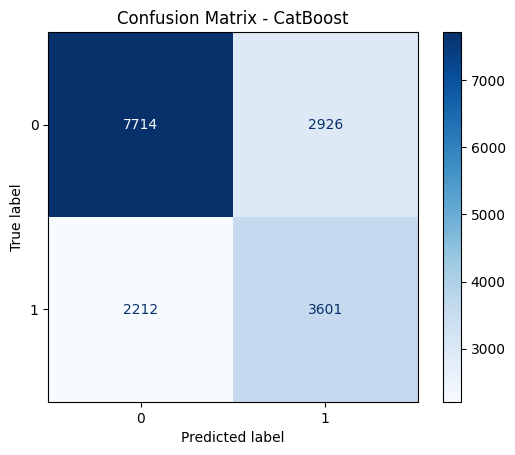

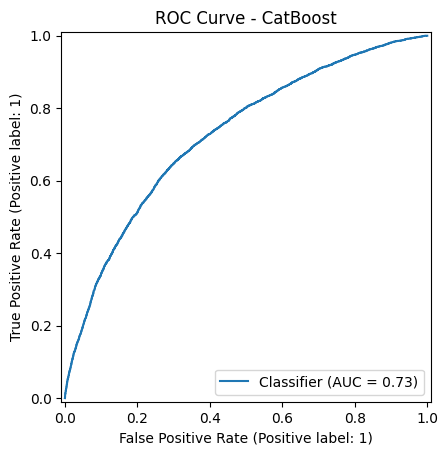

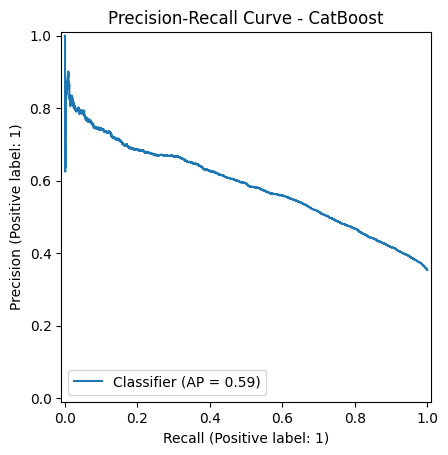

In [46]:
import catboost
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=1500,
    depth=6,
    learning_rate=0.025,
    l2_leaf_reg=7,
    random_strength=1,
    bagging_temperature=0.5,
    border_count=128,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=200,
    random_state=42
)

model_cat.fit(X_train, y_train, eval_set=(X_test, y_test))


# ============================================
# 2. Predictions
# ============================================
y_pred_cat = model_cat.predict(X_test)
y_pred_proba_cat = model_cat.predict_proba(X_test)[:, 1]

# ============================================
# 3. Evaluation Metrics
# ============================================
print("Accuracy :", accuracy_score(y_test, y_pred_cat))
print("Precision:", precision_score(y_test, y_pred_cat))
print("Recall   :", recall_score(y_test, y_pred_cat))
print("F1-Score :", f1_score(y_test, y_pred_cat))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_cat))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))

# ============================================
# 4. Confusion Matrix
# ============================================
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("ROC Curve - CatBoost")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("Precision-Recall Curve - CatBoost")
plt.show()


## SHAP Catboost

In [47]:
import shap

# Ambil data test
X_sample = X_test.copy()

# Buat explainer khusus CatBoost
explainer = shap.TreeExplainer(model_cat)

# Hitung shap values
shap_values = explainer.shap_values(X_sample)

c:\Users\Imtiy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
shap_interaction = explainer.shap_interaction_values(X_sample)

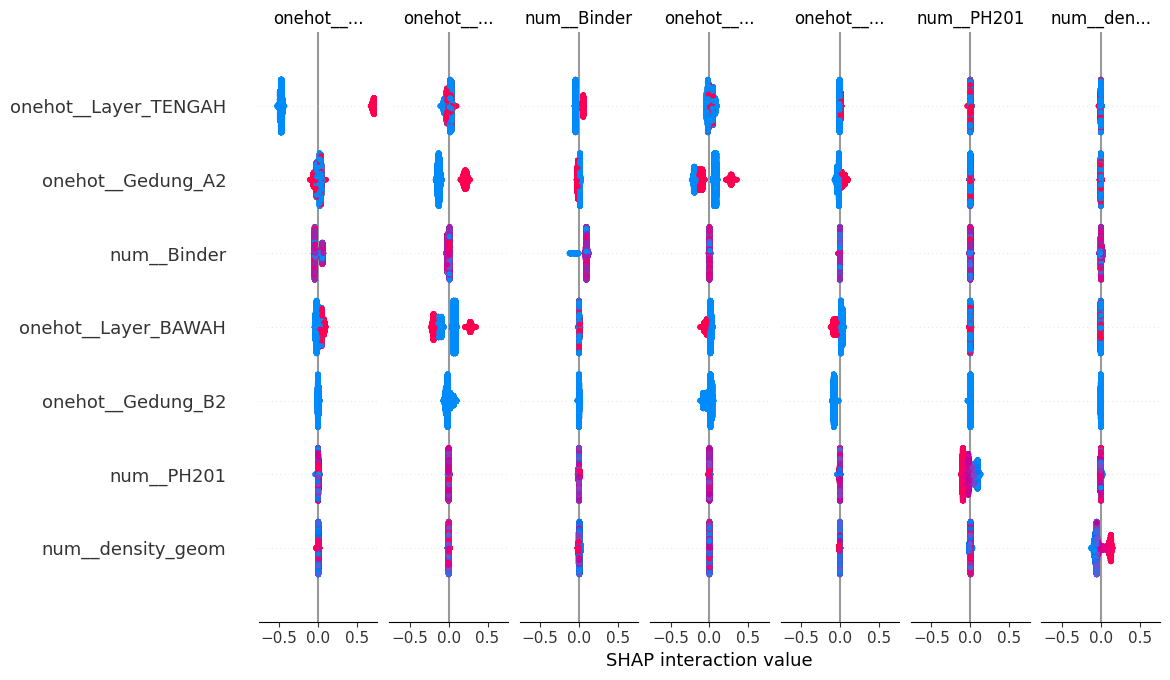

In [49]:
shap.summary_plot(shap_interaction, X_sample)

In [50]:
if isinstance(shap_values, list):
    shap_class1 = shap_values[1]
else:
    shap_class1 = shap_values

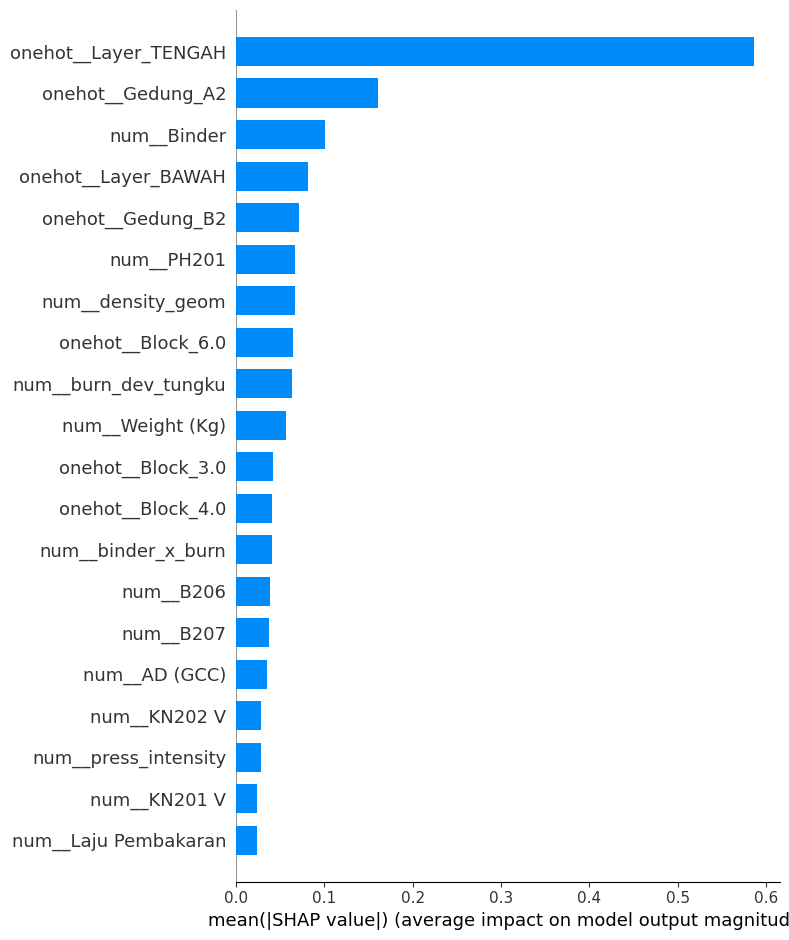

In [51]:
shap.summary_plot(shap_class1, X_sample, plot_type="bar")

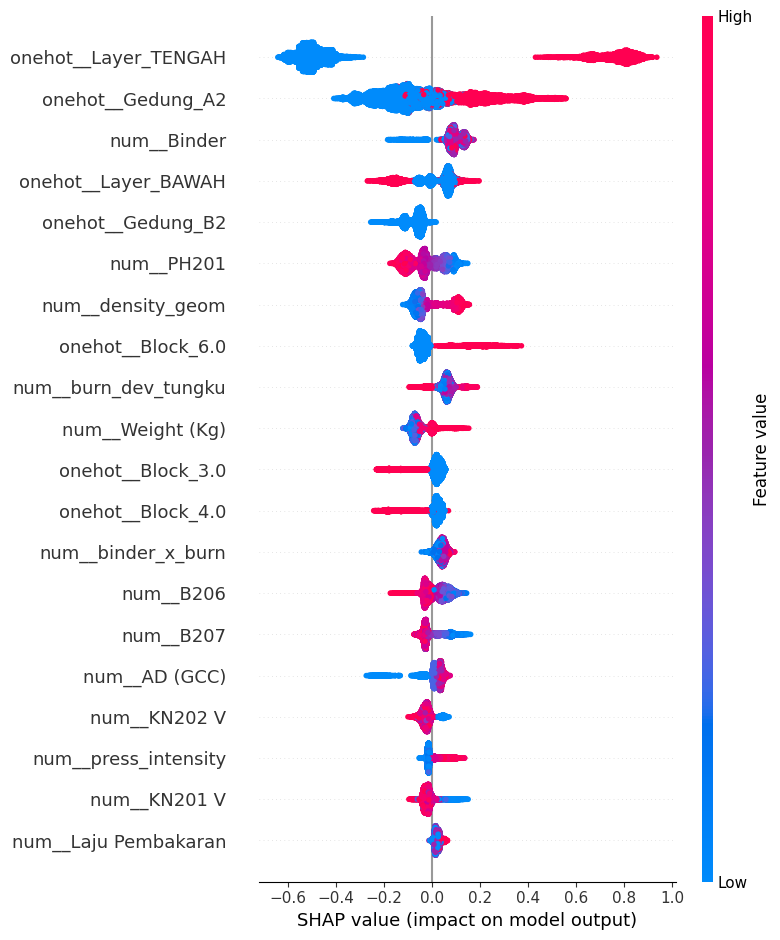

In [52]:
shap.summary_plot(shap_class1, X_sample)

## LGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19485, number of negative: 40347
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.042601
[LightGBM] [Debug] init for col-wise cost 0.000014 seconds, init for row-wise cost 0.016414 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13309
[LightGBM] [Info] Number of data points in the train set: 59832, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 a

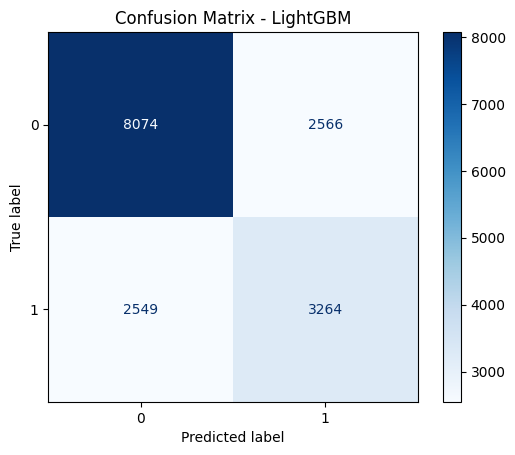

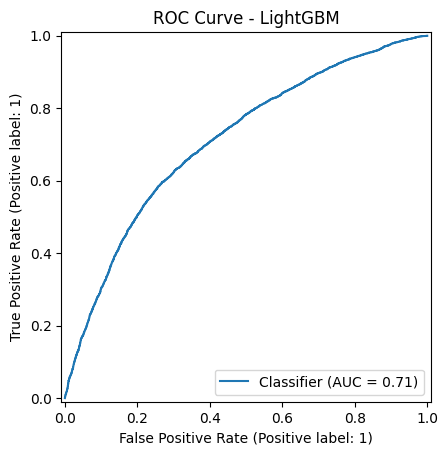

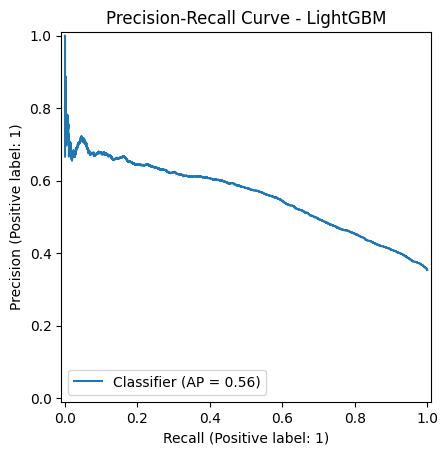

In [86]:
# ============================================
# 1. Train LightGBM (fast & efficient)
# ============================================
model_lgbm = LGBMClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    class_weight='balanced',
    verbose=50,
    metric='auc'
)

model_lgbm.fit(X_train, y_train)

# ============================================
# 2. Predictions
# ============================================
y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_proba_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

# ============================================
# 3. Evaluation Metrics
# ============================================
print("=" * 50)
print("LIGHTGBM MODEL EVALUATION")
print("=" * 50)
print("Accuracy :", accuracy_score(y_test, y_pred_lgbm))
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall   :", recall_score(y_test, y_pred_lgbm))
print("F1-Score :", f1_score(y_test, y_pred_lgbm))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_lgbm))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

# ============================================
# 4. Confusion Matrix
# ============================================
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LightGBM")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lgbm)
plt.title("ROC Curve - LightGBM")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_lgbm)
plt.title("Precision-Recall Curve - LightGBM")
plt.show()

## Random Forest

RANDOM FOREST MODEL EVALUATION
Accuracy : 0.6718531574788792
Precision: 0.5352760736196319
Recall   : 0.5403406158610012
F1-Score : 0.5377964215392518
ROC AUC  : 0.6733248914476109
PR AUC   : 0.5118787684670316

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75     10640
           1       0.54      0.54      0.54      5813

    accuracy                           0.67     16453
   macro avg       0.64      0.64      0.64     16453
weighted avg       0.67      0.67      0.67     16453



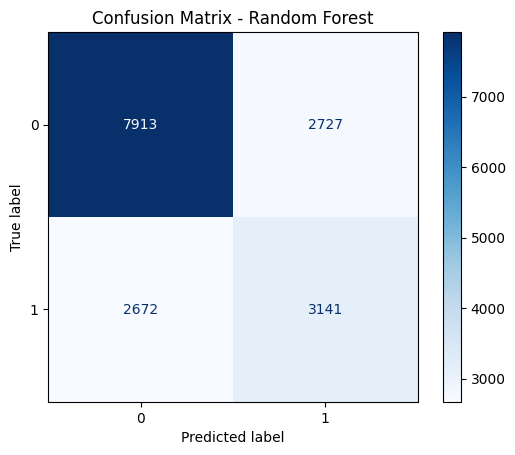

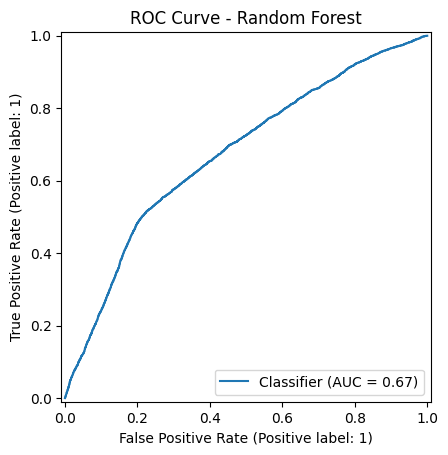

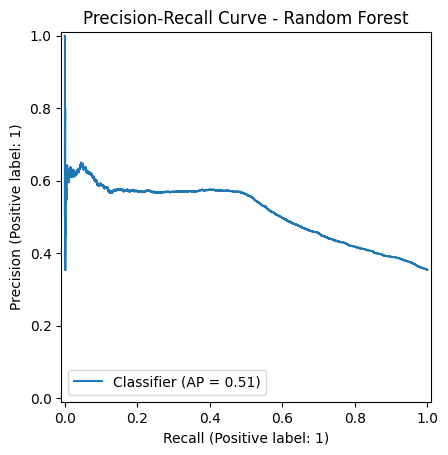

In [87]:
# ============================================
# 1. Train Random Forest
# ============================================
model_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

# ============================================
# 2. Predictions
# ============================================
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# ============================================
# 3. Evaluation Metrics
# ============================================
print("=" * 50)
print("RANDOM FOREST MODEL EVALUATION")
print("=" * 50)
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-Score :", f1_score(y_test, y_pred_rf))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_rf))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# ============================================
# 4. Confusion Matrix
# ============================================
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf)
plt.title("ROC Curve - Random Forest")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_rf)
plt.title("Precision-Recall Curve - Random Forest")
plt.show()

## XGBoost

XGBOOST MODEL EVALUATION
Accuracy : 0.688992888834863
Precision: 0.5737600678253497
Recall   : 0.4656803715809393
F1-Score : 0.5141012249548951
ROC AUC  : 0.6938139527814893
PR AUC   : 0.5446626129217715

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77     10640
           1       0.57      0.47      0.51      5813

    accuracy                           0.69     16453
   macro avg       0.65      0.64      0.64     16453
weighted avg       0.68      0.69      0.68     16453



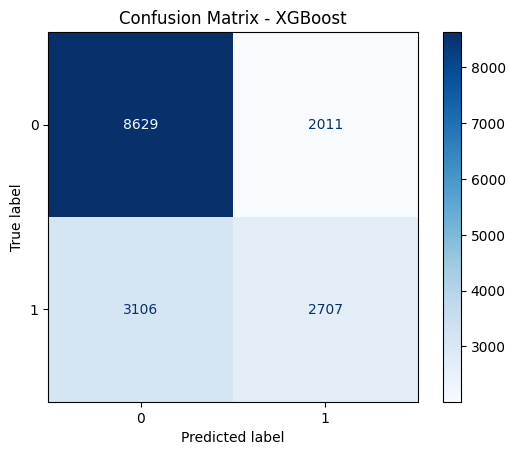

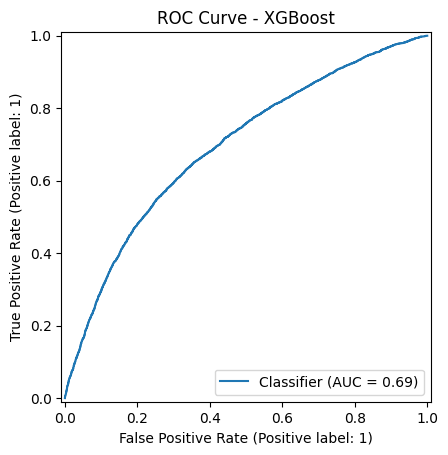

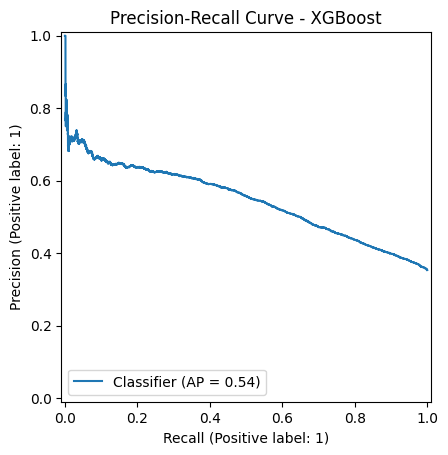

In [88]:
# ============================================
# 1. Train XGBoost Classifier
# ============================================
model_xgb = XGBClassifier(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train),  # imbalance
    random_state=42,
    tree_method='hist'
)

model_xgb.fit(X_train, y_train)

# ============================================
# 2. Predictions
# ============================================
y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# ============================================
# 3. Evaluation Metrics
# ============================================
print("=" * 50)
print("XGBOOST MODEL EVALUATION")
print("=" * 50)
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-Score :", f1_score(y_test, y_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_xgb))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# ============================================
# 4. Confusion Matrix
# ============================================
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
RocCurveDisplay.from_predictions(y_test, y_pred_proba_xgb)
plt.title("ROC Curve - XGBoost")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_xgb)
plt.title("Precision-Recall Curve - XGBoost")
plt.show()


## Tuning

In [89]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, average_precision_score

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test,  y_test)

In [90]:
from sklearn.model_selection import ParameterSampler

param_space = {
    "depth": [4,5,6,7,8],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.08],
    "l2_leaf_reg": [1,3,5,7,9,12],
    "random_strength": [0, 0.5, 1, 2, 5],
    "bagging_temperature": [0, 0.2, 0.5, 1, 2],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "rsm": [0.7, 0.8, 0.9, 1.0],
    "min_data_in_leaf": [1, 5, 10, 20, 50],
    # imbalance: coba beberapa bobot positif
    "pos_weight": [1.5, 2.0, 2.5, 3.0, 4.0]
}

n_iter = 25  # naikin ke 50 kalau mau lebih nendang
sampler = list(ParameterSampler(param_space, n_iter=n_iter, random_state=42))

best = {"score": -1, "params": None, "roc_auc": None, "pr_auc": None}

for i, p in enumerate(sampler, 1):
    model = CatBoostClassifier(
        iterations=4000,
        loss_function="Logloss",
        eval_metric="AUC",
        depth=p["depth"],
        learning_rate=p["learning_rate"],
        l2_leaf_reg=p["l2_leaf_reg"],
        random_strength=p["random_strength"],
        bagging_temperature=p["bagging_temperature"],
        subsample=p["subsample"],
        rsm=p["rsm"],
        min_data_in_leaf=p["min_data_in_leaf"],
        scale_pos_weight=p["pos_weight"],
        auto_class_weights=None,
        verbose=False,
        early_stopping_rounds=200
    )

    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    proba = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)

    # gabungkan metrik (lebih berat ke PR-AUC karena kamu peduli positive class)
    score = 0.65 * pr + 0.35 * roc

    if score > best["score"]:
        best = {"score": score, "params": p, "roc_auc": roc, "pr_auc": pr}
        print(f"[BEST so far #{i}] PR-AUC={pr:.4f} | ROC-AUC={roc:.4f} | params={p}")
    else:
        print(f"[{i}] PR-AUC={pr:.4f} | ROC-AUC={roc:.4f}")

best

[BEST so far #1] PR-AUC=0.5801 | ROC-AUC=0.7213 | params={'subsample': 0.9, 'rsm': 0.8, 'random_strength': 1, 'pos_weight': 4.0, 'min_data_in_leaf': 50, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'depth': 6, 'bagging_temperature': 0}
[2] PR-AUC=0.5781 | ROC-AUC=0.7201
[BEST so far #3] PR-AUC=0.5799 | ROC-AUC=0.7235 | params={'subsample': 0.7, 'rsm': 1.0, 'random_strength': 0, 'pos_weight': 4.0, 'min_data_in_leaf': 50, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'depth': 6, 'bagging_temperature': 0}
[BEST so far #4] PR-AUC=0.5885 | ROC-AUC=0.7295 | params={'subsample': 0.9, 'rsm': 1.0, 'random_strength': 0, 'pos_weight': 1.5, 'min_data_in_leaf': 5, 'learning_rate': 0.03, 'l2_leaf_reg': 7, 'depth': 7, 'bagging_temperature': 2}
[5] PR-AUC=0.5694 | ROC-AUC=0.7167
[6] PR-AUC=0.5756 | ROC-AUC=0.7195
[7] PR-AUC=0.5807 | ROC-AUC=0.7231
[8] PR-AUC=0.5868 | ROC-AUC=0.7253
[9] PR-AUC=0.5714 | ROC-AUC=0.7202
[10] PR-AUC=0.5736 | ROC-AUC=0.7176
[11] PR-AUC=0.5834 | ROC-AUC=0.7253
[12] PR-AUC=0.5684 | RO

{'score': 0.6378676812894515,
 'params': {'subsample': 0.9,
  'rsm': 1.0,
  'random_strength': 0,
  'pos_weight': 1.5,
  'min_data_in_leaf': 5,
  'learning_rate': 0.03,
  'l2_leaf_reg': 7,
  'depth': 7,
  'bagging_temperature': 2},
 'roc_auc': 0.729475805460667,
 'pr_auc': 0.5885402298126431}

0:	test: 0.6706048	best: 0.6706048 (0)	total: 37.6ms	remaining: 5m
200:	test: 0.7185526	best: 0.7185526 (200)	total: 6.91s	remaining: 4m 27s
400:	test: 0.7276519	best: 0.7278509 (347)	total: 13.3s	remaining: 4m 12s
600:	test: 0.7293413	best: 0.7293413 (600)	total: 20.1s	remaining: 4m 7s
800:	test: 0.7285700	best: 0.7294758 (603)	total: 26.5s	remaining: 3m 58s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7294758055
bestIteration = 603

Shrink model to first 604 iterations.
Accuracy : 0.6978058712696773
Precision: 0.5757248334233748
Recall   : 0.549974195768106
F1-Score : 0.5625549885623791
ROC AUC  : 0.729475805460667
PR AUC   : 0.5885402298126431

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     10640
           1       0.58      0.55      0.56      5813

    accuracy                           0.70     16453
   macro avg       0.67      0.66      0.67     16453
weighted avg       0.69 

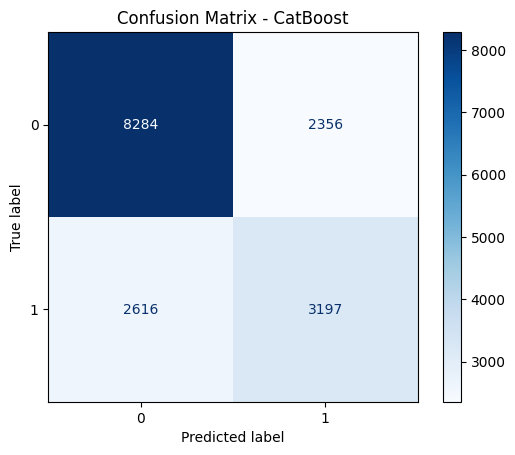

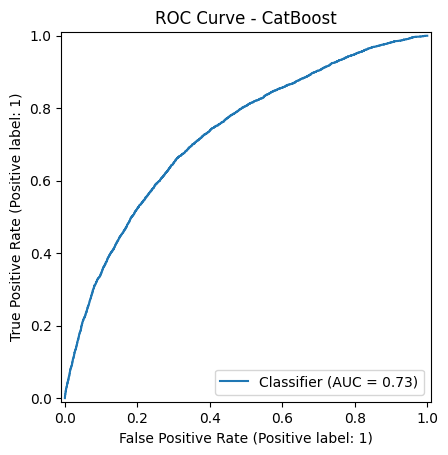

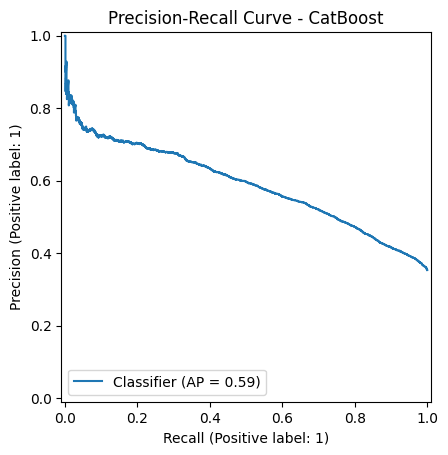

In [92]:
bp = best["params"]

final_model = CatBoostClassifier(
    iterations=8000,
    loss_function="Logloss",
    eval_metric="AUC",
    depth=bp["depth"],
    learning_rate=bp["learning_rate"],
    l2_leaf_reg=bp["l2_leaf_reg"],
    random_strength=bp["random_strength"],
    bagging_temperature=bp["bagging_temperature"],
    subsample=bp["subsample"],
    rsm=bp["rsm"],
    min_data_in_leaf=bp["min_data_in_leaf"],
    scale_pos_weight=bp["pos_weight"],
    verbose=200,
    early_stopping_rounds=300
)

final_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# ============================================
# 2. Predictions
# ============================================
y_pred_cat = final_model.predict(X_test)
y_pred_proba_cat = final_model.predict_proba(X_test)[:, 1]

# ============================================
# 3. Evaluation Metrics
# ============================================
print("Accuracy :", accuracy_score(y_test, y_pred_cat))
print("Precision:", precision_score(y_test, y_pred_cat))
print("Recall   :", recall_score(y_test, y_pred_cat))
print("F1-Score :", f1_score(y_test, y_pred_cat))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_cat))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))

# ============================================
# 4. Confusion Matrix
# ============================================
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("ROC Curve - CatBoost")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("Precision-Recall Curve - CatBoost")
plt.show()


In [93]:
from sklearn.metrics import precision_recall_curve

proba = final_model.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, proba)

# contoh pilih threshold recall >= 0.75
idx = np.where(rec >= 0.75)[0][-1]
best_thr = thr[idx-1] if idx > 0 else 0.5
best_thr

np.float64(0.35153904884973)

In [94]:
y_pred_custom = (proba >= best_thr).astype(int)

In [95]:
from sklearn.metrics import classification_report, confusion_matrix

print("Threshold:", best_thr)
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Threshold: 0.35153904884973
[[6211 4429]
 [1453 4360]]
              precision    recall  f1-score   support

           0       0.81      0.58      0.68     10640
           1       0.50      0.75      0.60      5813

    accuracy                           0.64     16453
   macro avg       0.65      0.67      0.64     16453
weighted avg       0.70      0.64      0.65     16453



Accuracy : 0.6424968090925667
Precision: 0.4960746387529867
Recall   : 0.7500430070531567
F1-Score : 0.5971784687029174
ROC AUC  : 0.729475805460667
PR AUC   : 0.5885402298126431

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.58      0.68     10640
           1       0.50      0.75      0.60      5813

    accuracy                           0.64     16453
   macro avg       0.65      0.67      0.64     16453
weighted avg       0.70      0.64      0.65     16453



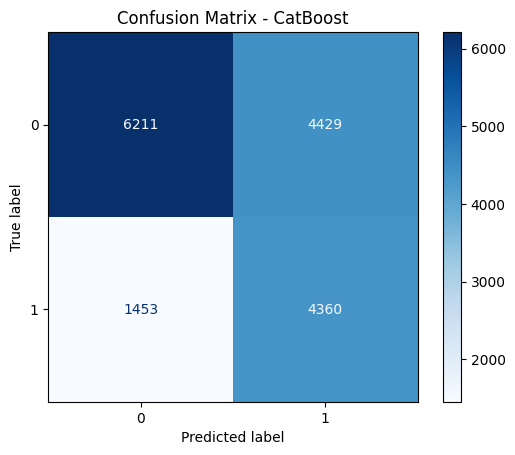

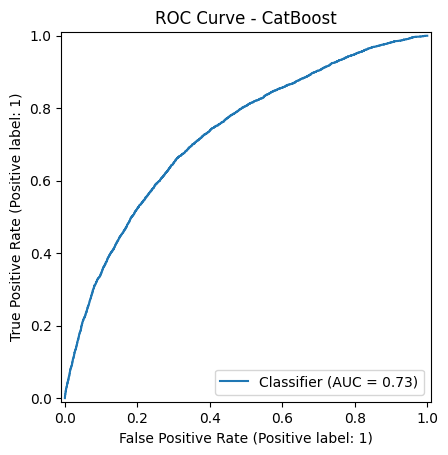

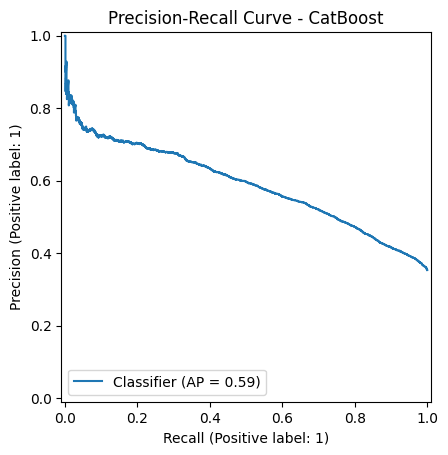

In [98]:
# ============================================
# 3. Evaluation Metrics
# ============================================
print("Accuracy :", accuracy_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall   :", recall_score(y_test, y_pred_custom))
print("F1-Score :", f1_score(y_test, y_pred_custom))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_proba_cat))
print("PR AUC   :", average_precision_score(y_test, y_pred_proba_cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

# ============================================
# 4. Confusion Matrix
# ============================================
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.show()

# ============================================
# 5. Plot ROC Curve
# ============================================
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("ROC Curve - CatBoost")
plt.show()

# ============================================
# 6. Plot Precision–Recall Curve
# ============================================
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_cat)
plt.title("Precision-Recall Curve - CatBoost")
plt.show()


## Ensemble

In [100]:
from sklearn.metrics import roc_auc_score, average_precision_score

proba_cat = model_cat.predict_proba(X_test)[:, 1]
proba_lgb = model_lgbm.predict_proba(X_test)[:, 1]

# bobot bisa diubah (mis: CatBoost lebih kuat -> 0.6/0.4)
w_cat, w_lgb = 0.7, 0.3
proba_ens = (w_cat * proba_cat + w_lgb * proba_lgb) / (w_cat + w_lgb)

print("CatBoost  ROC-AUC:", roc_auc_score(y_test, proba_cat))
print("CatBoost  PR-AUC :", average_precision_score(y_test, proba_cat))

print("LightGBM  ROC-AUC:", roc_auc_score(y_test, proba_lgb))
print("LightGBM  PR-AUC :", average_precision_score(y_test, proba_lgb))

print("Ensemble  ROC-AUC:", roc_auc_score(y_test, proba_ens))
print("Ensemble  PR-AUC :", average_precision_score(y_test, proba_ens))

CatBoost  ROC-AUC: 0.7263757891632573
CatBoost  PR-AUC : 0.5863172543840481
LightGBM  ROC-AUC: 0.7106581178561404
LightGBM  PR-AUC : 0.5572390033476815
Ensemble  ROC-AUC: 0.7254781705252292
Ensemble  PR-AUC : 0.5820595235041995


# EDA

## Crack rate per layer

In [53]:
df_eda = df_fe.copy()

layer_crack = (
    df_eda.groupby("Layer")["Crack General"]
    .mean()
    .sort_values(ascending=False)
)

layer_count = df_eda["Layer"].value_counts()

layer_summary = pd.concat(
    [layer_crack.rename("crack_rate"), layer_count.rename("n")],
    axis=1
)

layer_summary


,crack_rate,n
Layer,,
TENGAH,0.515443,27456
BAWAH,0.243975,27261
ATAS,0.242558,27548


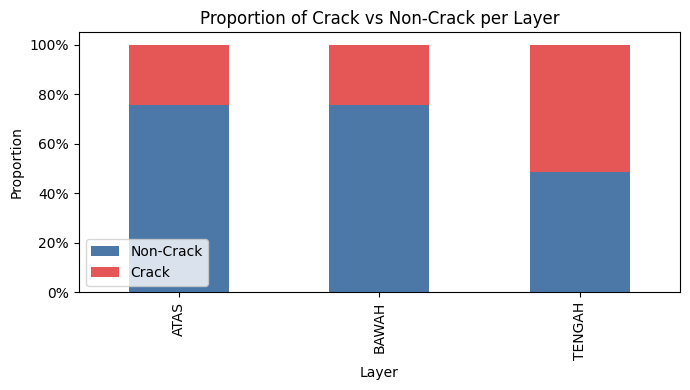

In [54]:
import matplotlib.pyplot as plt

tmp = (
    df_eda.groupby(["Layer","Crack General"])
    .size()
    .unstack(fill_value=0)
)

tmp_pct = tmp.div(tmp.sum(axis=1), axis=0)

ax = tmp_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(7,4),
    color=["#4C78A8", "#E45756"]  # biru & merah lembut
)

plt.ylabel("Proportion")
plt.xlabel("Layer")
plt.title("Proportion of Crack vs Non-Crack per Layer")
plt.legend(["Non-Crack","Crack"], loc="lower left")

# format persen di y-axis
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

plt.tight_layout()
plt.show()


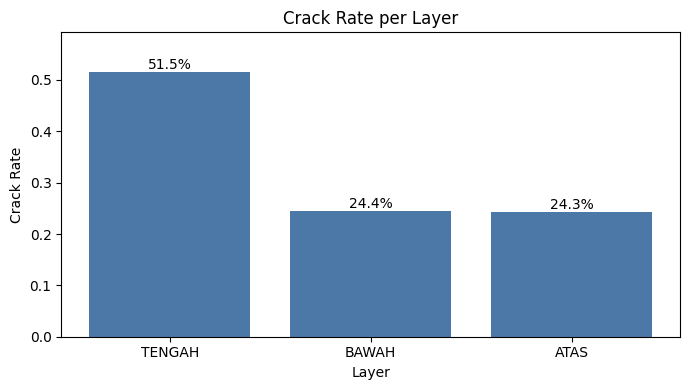

In [55]:
layer_summary = layer_summary.sort_values("crack_rate", ascending=False)

plt.figure(figsize=(7,4))
bars = plt.bar(
    layer_summary.index,
    layer_summary["crack_rate"],
    color="#4C78A8"
)

plt.ylabel("Crack Rate")
plt.xlabel("Layer")
plt.title("Crack Rate per Layer")

# angka di atas bar
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{h:.1%}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylim(0, layer_summary["crack_rate"].max()*1.15)
plt.tight_layout()
plt.show()

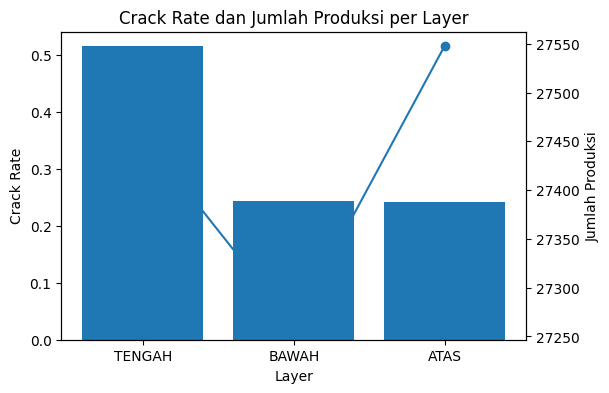

In [56]:
fig, ax1 = plt.subplots(figsize=(6,4))

# bar crack rate
ax1.bar(layer_summary.index, layer_summary["crack_rate"])
ax1.set_ylabel("Crack Rate")
ax1.set_xlabel("Layer")

# axis kedua untuk jumlah data
ax2 = ax1.twinx()
ax2.plot(layer_summary.index, layer_summary["n"], marker="o")
ax2.set_ylabel("Jumlah Produksi")

ax1.set_title("Crack Rate dan Jumlah Produksi per Layer")
plt.show()

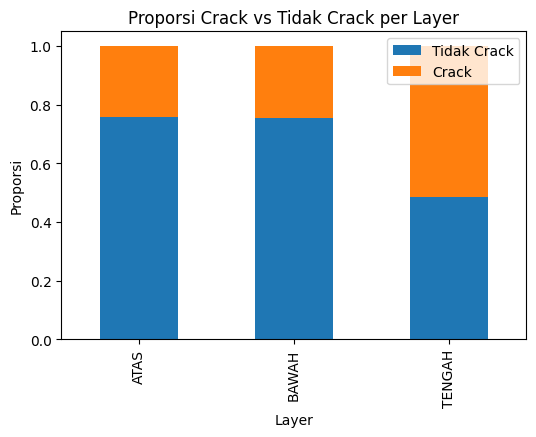

In [57]:
tmp = (
    df_eda.groupby(["Layer","Crack General"])
    .size()
    .unstack(fill_value=0)
)

tmp_pct = tmp.div(tmp.sum(axis=1), axis=0)

tmp_pct.plot(kind="bar", stacked=True, figsize=(6,4))
plt.ylabel("Proporsi")
plt.title("Proporsi Crack vs Tidak Crack per Layer")
plt.legend(["Tidak Crack","Crack"])
plt.show()

## Gedung A2

In [58]:
gedung_summary = (
    df_eda.groupby("Gedung")["Crack General"]
    .agg(["mean","count"])
    .rename(columns={"mean":"crack_rate","count":"n"})
    .sort_values("crack_rate", ascending=False)
)

gedung_summary

,crack_rate,n
Gedung,,
A2,0.366883,29846
B1,0.362702,11089
B2,0.339180,11003
A1,0.289544,30327


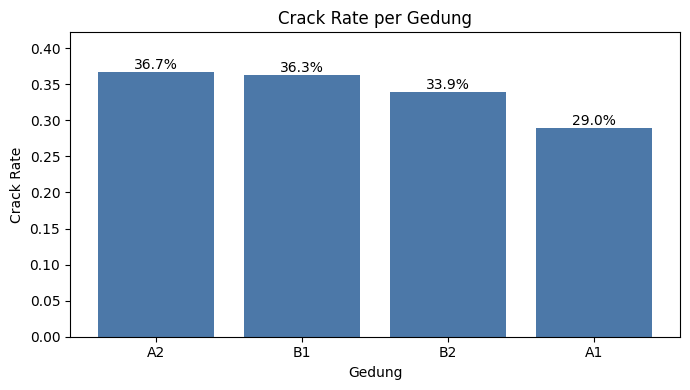

In [59]:
import matplotlib.pyplot as plt

gedung_summary = gedung_summary.sort_values("crack_rate", ascending=False)

plt.figure(figsize=(7,4))
bars = plt.bar(
    gedung_summary.index,
    gedung_summary["crack_rate"],
    color="#4C78A8"
)

plt.ylabel("Crack Rate")
plt.xlabel("Gedung")
plt.title("Crack Rate per Gedung")

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{h:.1%}",
        ha="center",
        va="bottom"
    )

plt.ylim(0, gedung_summary["crack_rate"].max()*1.15)
plt.tight_layout()
plt.show()

In [60]:
df_eda["is_A2"] = (df_eda["Gedung"] == "A2").astype(int)

df_eda.groupby("is_A2")["Crack General"].mean()

is_A2
0    0.315439
1    0.366883
Name: Crack General, dtype: float64

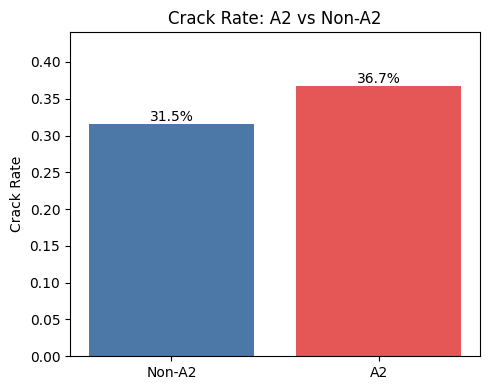

In [61]:
a2_rate = df_eda.groupby("is_A2")["Crack General"].mean()
a2_rate.index = ["Non-A2", "A2"]

plt.figure(figsize=(5,4))
bars = plt.bar(a2_rate.index, a2_rate.values, color=["#4C78A8", "#E45756"])

plt.ylabel("Crack Rate")
plt.title("Crack Rate: A2 vs Non-A2")

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{h:.1%}",
        ha="center",
        va="bottom"
    )

plt.ylim(0, max(a2_rate.values)*1.2)
plt.tight_layout()
plt.show()

## Binder

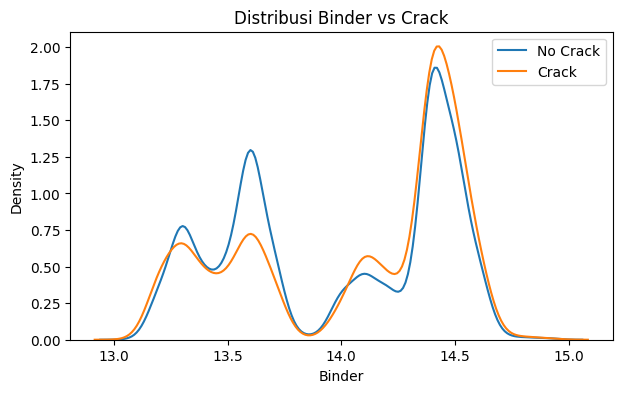

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.kdeplot(df_eda[df_eda["Crack General"]==0]["Binder"], label="No Crack")
sns.kdeplot(df_eda[df_eda["Crack General"]==1]["Binder"], label="Crack")
plt.legend()
plt.title("Distribusi Binder vs Crack")
plt.show()

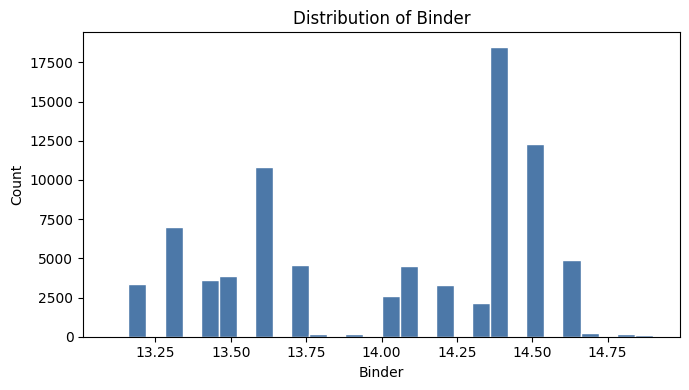

In [63]:
plt.figure(figsize=(7,4))
plt.hist(df_eda["Binder"], bins=30, color="#4C78A8", edgecolor="white")
plt.xlabel("Binder")
plt.ylabel("Count")
plt.title("Distribution of Binder")
plt.tight_layout()
plt.show()

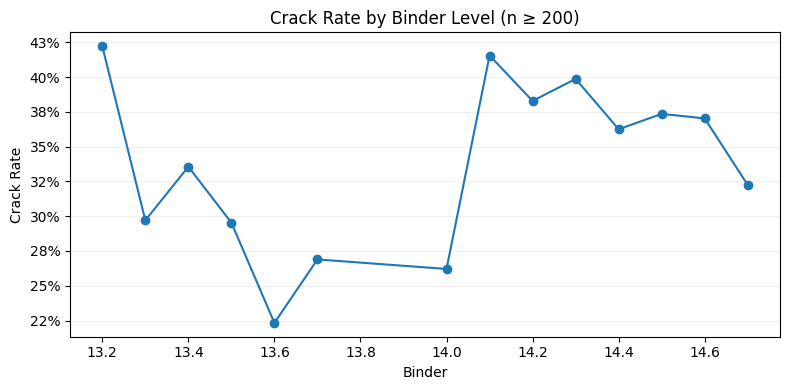

In [64]:
binder_rate = (
    df_eda.groupby("Binder")["Crack General"]
    .agg(crack_rate="mean", n="count")
    .reset_index()
)

# filter biar stabil (buang yang n kecil)
binder_rate_f = binder_rate[binder_rate["n"] >= 200].sort_values("Binder")

plt.figure(figsize=(8,4))
plt.plot(binder_rate_f["Binder"], binder_rate_f["crack_rate"], marker="o")
plt.xlabel("Binder")
plt.ylabel("Crack Rate")
plt.title("Crack Rate by Binder Level (n ≥ 200)")
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()


C:\Users\Imtiy\AppData\Local\Temp\ipykernel_15132\3279116396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eda.groupby("binder_bin")["Crack General"]


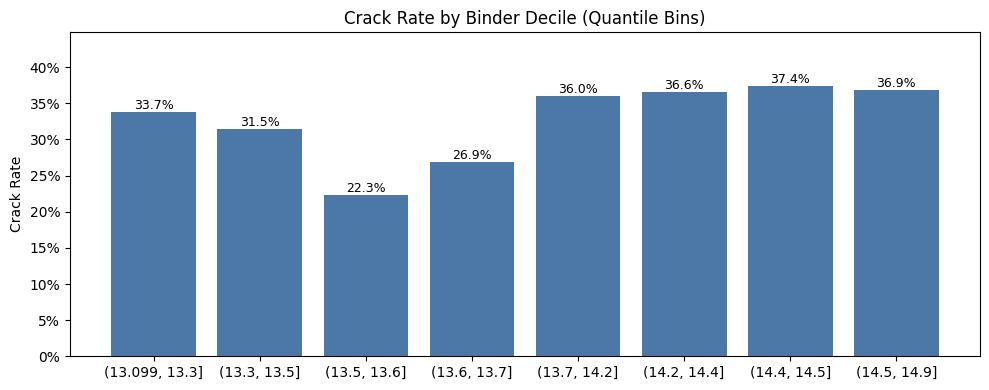

In [71]:
df_eda["binder_bin"] = pd.qcut(df_eda["Binder"], q=10, duplicates="drop")

bin_summary = (
    df_eda.groupby("binder_bin")["Crack General"]
    .agg(crack_rate="mean", n="count")
    .reset_index()
)

plt.figure(figsize=(10,4))
bars = plt.bar(range(len(bin_summary)), bin_summary["crack_rate"], color="#4C78A8")

plt.xticks(range(len(bin_summary)), bin_summary["binder_bin"].astype(str), rotation=0, ha="center")
plt.ylabel("Crack Rate")
plt.title("Crack Rate by Binder Decile (Quantile Bins)")
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

# label % di atas bar
for i, v in enumerate(bin_summary["crack_rate"]):
    plt.text(i, v, f"{v:.1%}", ha="center", va="bottom", fontsize=9)

plt.ylim(0, bin_summary["crack_rate"].max()*1.2)
plt.tight_layout()
plt.show()


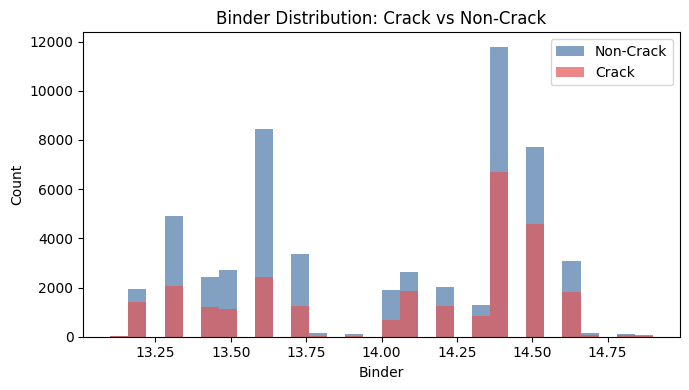

In [65]:
plt.figure(figsize=(7,4))

plt.hist(df_eda.loc[df_eda["Crack General"]==0, "Binder"], bins=30, alpha=0.7, label="Non-Crack", color="#4C78A8")
plt.hist(df_eda.loc[df_eda["Crack General"]==1, "Binder"], bins=30, alpha=0.7, label="Crack", color="#E45756")

plt.xlabel("Binder")
plt.ylabel("Count")
plt.title("Binder Distribution: Crack vs Non-Crack")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Imtiy\AppData\Local\Temp\ipykernel_15132\1498247537.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_eda.pivot_table(


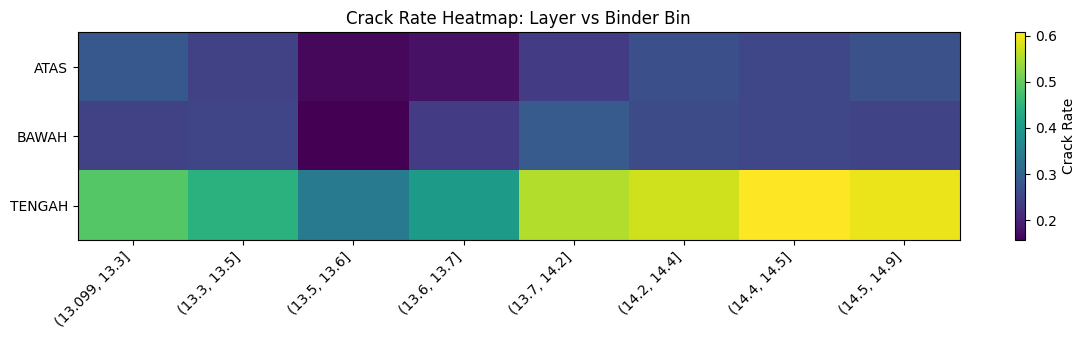

In [68]:
pivot = (
    df_eda.pivot_table(
        index="Layer",
        columns="binder_bin",
        values="Crack General",
        aggfunc="mean"
    )
)

plt.figure(figsize=(12,3.5))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Crack Rate")
plt.xticks(range(pivot.shape[1]), pivot.columns.astype(str), rotation=45, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.title("Crack Rate Heatmap: Layer vs Binder Bin")
plt.tight_layout()
plt.show()
